# Предсказываем зарплату по вакансии

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("Train_rev1.csv", index_col=None)
raw_data = data.copy()
raw_data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


# Разберемся с категориальными данными и зависимой переменной

Оставим только нормализованные данные.

In [3]:
del data['LocationRaw']
del data['SalaryRaw']

In [4]:
data_mod = data.copy()

In [5]:
#Посмотрим на пропуски
data_mod.isnull().sum()

Id                         0
Title                      1
FullDescription            0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryNormalized           0
SourceName                 1
dtype: int64

In [6]:
#У типа и времени контракта слишком много пропусков (не хватает памяти на обработку всего)

del data['ContractType']
del data['ContractTime']

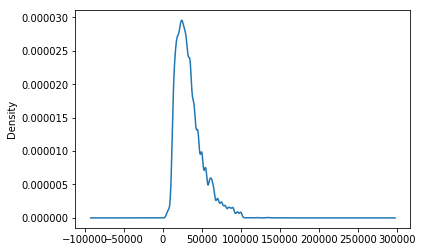

In [7]:
data['SalaryNormalized'].plot.kde()

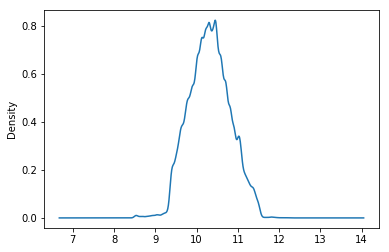

In [8]:
#Проблема с правым хвостом, зависимой переменной возьем логарифм зарплаты

data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

data['Log1pSalary'].plot.kde()

In [9]:
#Стало лучше

del data['SalaryNormalized']

In [10]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN')
cat_data = data[categorical_columns]

In [11]:
#Посмотрим, на кол-во повторений категорильных переменных

for i in cat_data:
    print('TITLE:', i)
    print(cat_data[i].value_counts())
    print('--------------------------------')

TITLE: Category
IT Jobs                             38483
Engineering Jobs                    25174
Accounting & Finance Jobs           21846
Healthcare & Nursing Jobs           21076
Sales Jobs                          17272
Other/General Jobs                  17055
Teaching Jobs                       12637
Hospitality & Catering Jobs         11351
PR, Advertising & Marketing Jobs     8854
Trade & Construction Jobs            8837
HR & Recruitment Jobs                7713
Admin Jobs                           7614
Retail Jobs                          6584
Customer Services Jobs               6063
Legal Jobs                           3939
Manufacturing Jobs                   3765
Logistics & Warehouse Jobs           3633
Social work Jobs                     3455
Consultancy Jobs                     3263
Travel Jobs                          3126
Scientific & QA Jobs                 2489
Charity & Voluntary Jobs             2332
Energy, Oil & Gas Jobs               2255
Creative & Design 

In [12]:
#Приводим категориальные переменные в надлежащий вид

from sklearn.feature_extraction import DictVectorizer
import collections

# Рассматриваем только 100 наиболее популярных компаний
rec_comp = []
top_companies = collections.Counter(data['Company']).most_common(1000)
for i in top_companies:
    rec_comp.append(i[0])
recognized_companies = set(rec_comp)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

# Рассматриваем только 100 наиболее популярных мест
pop_loc = []
top_loc = collections.Counter(data['LocationNormalized']).most_common(1000)
for i in top_loc:
    pop_loc.append(i[0])
pop_locations = set(pop_loc)
data['LocationNormalized'] = data['LocationNormalized'].apply(lambda loc: loc if loc in pop_locations else "Other")

# Рассматриваем только 100 наиболее популярных сайтов
pop_www = []
top_www = collections.Counter(data['SourceName']).most_common(1000)
for i in top_www:
    pop_www.append(i[0])
popular_www = set(pop_www)
data['SourceName'] = data['SourceName'].apply(lambda www: www if www in popular_www else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(cat_data.apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

# Поработаем с описанием и заголовком вакансии

In [13]:
import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
import re

In [14]:
#Удаляем символы
data['FullDescription'] = data['FullDescription'].apply(lambda x: re.sub('[!@#$;:%-&?<>*)(=_*/+}{|.,]','',x))
data['FullDescription'] = data['FullDescription'].apply(lambda x: re.sub('\d+','',x))

In [15]:
#приводим к нижнему регистру
lower_descr = []
for s in data['FullDescription']:
    lower_descr.append(s.lower())

data['FullDescription'] = lower_descr

In [16]:
data['Title'] = data['Title'].astype(str)
lower_title = []
for s in data['Title']:
    lower_title.append(s.lower())

data['Title'] = lower_title

In [17]:
del data['Id']

In [18]:
#Делаем токенизацию и лемматизацию

nltk.download('wordnet')

lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
data['FullDescription'] = data['FullDescription'].apply(lemmatize_text)

In [20]:
data['Title'] = data['Title'].apply(lemmatize_text)

Преобразуем данные

In [21]:
data.head()

,Title,FullDescription,LocationNormalized,Company,Category,SourceName,Log1pSalary
0,"[engineering, system, analyst]","[engineering, system, analyst, dorking, surrey...",Dorking,Gregory Martin International,Engineering Jobs,cv-library.co.uk,10.126671
1,"[stress, engineer, glasgow]","[stress, engineer, glasgow, salary, to, we, re...",Glasgow,Gregory Martin International,Engineering Jobs,cv-library.co.uk,10.308986
2,"[modelling, and, simulation, analyst]","[mathematical, modeller, simulation, analyst, ...",Hampshire,Gregory Martin International,Engineering Jobs,cv-library.co.uk,10.308986
3,"[engineering, system, analyst, /, mathematical...","[engineering, system, analyst, mathematical, m...",Surrey,Gregory Martin International,Engineering Jobs,cv-library.co.uk,10.221977
4,"[pioneer,, miser, engineering, system, analyst]","[pioneer, miser, engineering, system, analyst,...",Surrey,Gregory Martin International,Engineering Jobs,cv-library.co.uk,10.126671


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [23]:
#Превращаем список списков в список строк
data['Title'] = [' '.join(x) for x in data['Title']]

In [24]:
data['FullDescription'] = [' '.join(x) for x in data['FullDescription']]

In [25]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=43)

In [26]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True,
                                   strip_accents='unicode',
                                   stop_words='english',
                                  analyzer='word',
                                  ngram_range=(1,1),
                                   max_features=500)

In [27]:
tfidf_vectorizer.fit(data_train['FullDescription'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [28]:
train_descr = tfidf_vectorizer.transform(data_train['FullDescription'])
test_descr = tfidf_vectorizer.transform(data_val['FullDescription'])

In [29]:
train_descr.shape

(195814, 500)

In [30]:
tfidf_vectorizer.fit(data_train['Title'])

train_title = tfidf_vectorizer.transform(data_train['Title'])
test_title = tfidf_vectorizer.transform(data_val['Title'])

In [31]:
type(train_title)

scipy.sparse.csr.csr_matrix

In [32]:
cat_train = categorical_vectorizer.transform(data_train[categorical_columns].apply(dict, axis=1))
cat_test = categorical_vectorizer.transform(data_val[categorical_columns].apply(dict, axis=1))

In [33]:
type(cat_train)

numpy.ndarray

Приведем в более читабельный вид

In [34]:
train_title_df = pd.DataFrame(train_title.todense())
train_descr_df = pd.DataFrame(train_descr.todense())

In [35]:
train_cat_df = pd.DataFrame(cat_train)

In [36]:
test_cat_df = pd.DataFrame(cat_test)

In [37]:
train_cat_df.shape

(195814, 23574)

Понизим размерность данных

In [38]:
import umap

In [39]:
reducer = umap.UMAP()

train_cat_df = reducer.fit_transform(train_cat_df)
test_cat_df = reducer.transform(test_cat_df)
train_cat_df.shape

MemoryError: Unable to allocate array with shape (54629, 23574) and data type float32

In [ ]:
test_title_df = pd.DataFrame(test_title.todense())
test_descr_df = pd.DataFrame(test_descr.todense())

In [ ]:
reducer = umap.UMAP()

train_title_df = reducer.fit_transform(train_title_df)
test_title_df = reducer.transform(test_title_df)
train_title_df.shape

In [ ]:
reducer = umap.UMAP()

train_descr_df = reducer.fit_transform(train_descr_df)
test_descr_df = reducer.transform(test_descr_df)
train_descr_df.shape

In [ ]:
#Слепим все вместе

x = pd.concat([train_cat_df, train_title_df])
X = pd.concat([x, train_descr_df])

x_val = pd.concat([test_cat_df, test_title_df])
X_val = pd.concat([x_val, test_descr_df])

Y = data_train['Log1pSalary']
Y_val = data_val['Log1pSalary'']

# Моделирование

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [ ]:
#Лассо
model = Lasso()
model.fit(X, Y)

y_pred = model.predict(X_val)

mae = mean_absolute_error(Y_val, y_pred)
R2 = r2_score(Y_val, y_pred)
mse = mean_squared_error(Y_val, y_pred)

print('MSE', mse)
print('R2:', R2)
print('MAE:', mae)

#Кросс-валидация
scores = cross_val_score(model, X, Y, cv=5,
                        scoring='r2')
print('Average CV:', scores.mean())

sns.scatterplot(Y_val, y_pred)

In [ ]:
#Ридж
model = Ridge()
model.fit(X, Y)

y_pred = model.predict(X_val)

mae = mean_absolute_error(Y_val, y_pred)
R2 = r2_score(Y_val, y_pred)
mse = mean_squared_error(Y_val, y_pred)

print('MSE', mse)
print('R2:', R2)
print('MAE:', mae)

#Кросс-валидация
scores = cross_val_score(model, X, Y, cv=5,
                        scoring='r2')
print('Average CV:', scores.mean())

sns.scatterplot(Y_val, y_pred)

In [ ]:
#SVM
model = svm.LinearSVR()
model.fit(X, Y)

y_pred = model.predict(X_val)

mae = mean_absolute_error(Y_val, y_pred)
R2 = r2_score(Y_val, y_pred)
mse = mean_squared_error(Y_val, y_pred)

print('MSE', mse)
print('R2:', R2)
print('MAE:', mae)

#Кросс-валидация
scores = cross_val_score(model, X, Y, cv=5,
                        scoring='r2')
print('Average CV:', scores.mean())

sns.scatterplot(Y_val, y_pred)

Деревья

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Лес
model = RandomForestRegressor()
model.fit(X, Y)

y_pred = model.predict(X_val)

mae = mean_absolute_error(Y_val, y_pred)
R2 = r2_score(Y_val, y_pred)
mse = mean_squared_error(Y_val, y_pred)

print('MSE', mse)
print('R2:', R2)
print('MAE:', mae)


scores = cross_val_score(model, X, Y, cv=5,
                         scoring='r2')
print('Average value on cross-validation:',scores.mean())

sns.scatterplot(Y_val, y_pred)

LSTM

In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [ ]:
MAX_NB_WORDS = 3000

MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [ ]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(Y_val, y_pred)
R2 = r2_score(Y_val, y_pred)
mse = mean_squared_error(Y_val, y_pred)

print('MSE', mse)
print('R2:', R2)
print('MAE:', mae)

#Кросс-валидация
scores = cross_val_score(model, X, Y, cv=5,
                        scoring='r2')
print('Average CV:', scores.mean())

sns.scatterplot(Y_val, y_pred)

In [ ]:
Выводы сделать сложно, потому что начиная с понижения размерности, код работает нестабильно из-за высоких требований к памяти. 